In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import random
%matplotlib inline

In [3]:
data_dir='processed_datasets'
os.listdir(data_dir)

['gender_ids_15_second_test.npy',
 'Sex_y_15_xtremefiltered.npy',
 'gender_X_15.npy',
 'Age_X_15_xtremefiltered.npy',
 'Sex_ids_15_filtered.npy',
 'jointProblem_y_15.npy',
 'age_y_train.npy',
 'jointProblem_X_15.npy',
 'gender_y_15.npy',
 'Age_ids_15_xtremefiltered.npy',
 'heartCondition_ids_15.npy',
 'age_y_val.npy',
 'BMI_y_15_xtremefiltered.npy',
 'Sex_X_15_filtered.npy',
 'BMI_y_val.npy',
 'BMI_X_train.npy',
 'BMI_binned_X_val.npy',
 'BMI_y_15_second_test.npy',
 'BMI_ids_15_second_test.npy',
 'Age_y_15_xtremefiltered.npy',
 'BMI_y_15_filtered.npy',
 'Age_X_15_filtered.npy',
 'BMI_X_15_filtered.npy',
 'heartCondition_y_15.npy',
 'age_y_15.npy',
 'jointProblem_ids_15.npy',
 'gender_X_val.npy',
 'gender_y_15_second_test.npy',
 'age_X_val.npy',
 'Sex_ids_15_xtremefiltered.npy',
 'BMI_binned_y_train.npy',
 'BMI_X_15.npy',
 'Sex_X_15_xtremefiltered.npy',
 'gender_y_train.npy',
 'age_X_train.npy',
 'BMI_binned_X_train.npy',
 'gender_X_train.npy',
 'BMI_X_15_second_test.npy',
 'BMI_ids_15.

In [11]:

print('Beginning loading')

X_train = np.load('processed_datasets/Sex_X_15_aligned.npy')
y_train = np.load('processed_datasets/Sex_y_15_aligned.npy')
ids_train = np.load('processed_datasets/Sex_ids_15_aligned.npy')

print('Finished loading, beginning X_train axis adjustment')

#Change X_train to weird format
X_train = np.expand_dims(X_train, 1)
X_train = np.swapaxes(X_train, -1, -2)

print('Beginning y_train encoding')

#Convert string to binary labels
y_train = y_train == 'Male'

#Randomize
if False:
    print('Data will be randomized.')
    idxs = np.arange(X_train.shape[0])
    np.random.shuffle(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]
    ids_train = ids_train[idxs]
else:
    print('Data is NOT randomized.')

print('Beginning data splitting')

split_num = int(0.8*X_train.shape[0])
X_test = X_train[split_num:]
y_test = y_train[split_num:]
ids_test = ids_train[split_num:]

X_train = X_train[:split_num]
y_train = y_train[:split_num]
ids_train = ids_train[:split_num]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, ids_train.shape, ids_test.shape)

Beginning loading
Finished loading, beginning X_train axis adjustment
Beginning y_train encoding
Data is NOT randomized.
Beginning data splitting
(433563, 1, 15, 100) (108391, 1, 15, 100) (433563,) (108391,) (433563,) (108391,)


#  Data visualization:
Let us look at User-0's training data.

In [31]:
X_train_0=X_train[ids_train=='0288cd6a-4ecd-46c5-9e9a-10ae835f9adb',0,:,:]
X_train_0.shape

(613, 15, 100)

In [30]:
from scipy import stats
stats.mode(ids_train)

ModeResult(mode=array(['0288cd6a-4ecd-46c5-9e9a-10ae835f9adb'], dtype='<U36'), count=array([613]))

Text(0, 0.5, 'Accelerometric measurements \n $a_{mag}=\\sqrt{a_x^2+a_y^2+a_z^2}$')

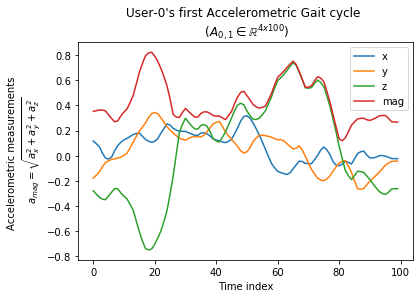

In [32]:
plt.plot(X_train_0[1,0:4].T);
plt.legend(['x','y','z','mag'])
plt.title('User-0\'s first Accelerometric Gait cycle \n ($A_{0,1}\in \mathbb{R}^{4 x 100}$)')
plt.xlabel('Time index')
plt.ylabel('Accelerometric measurements \n $a_{mag}=\sqrt{a_x^2+a_y^2+a_z^2}$')

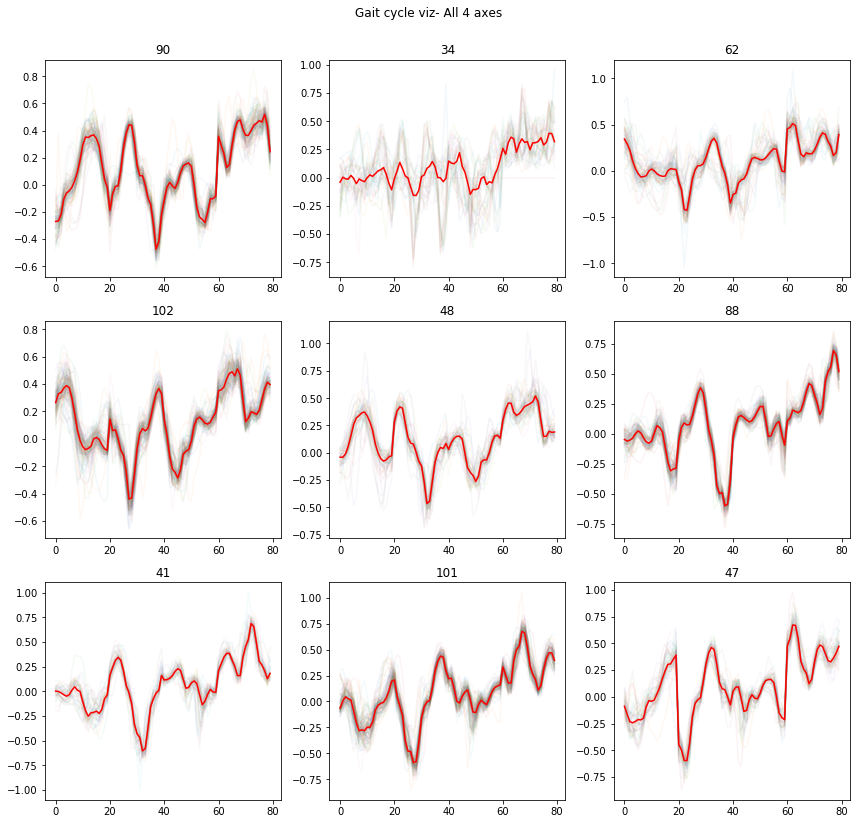

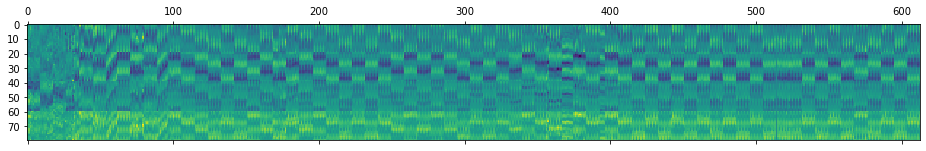

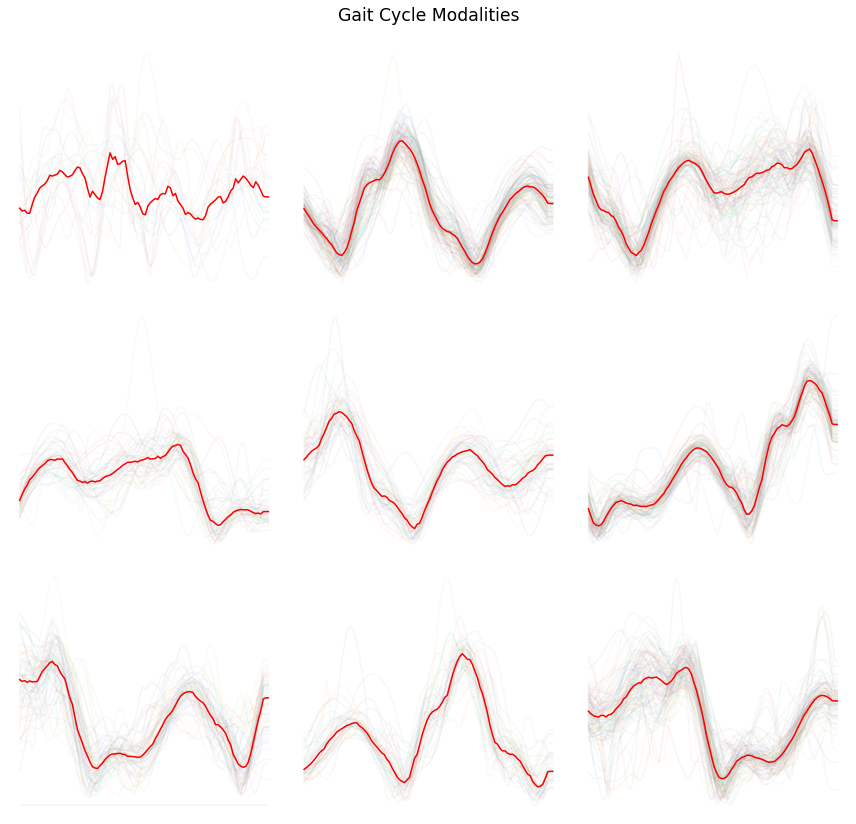

In [38]:
from sklearn.cluster import KMeans

def cluster_viz(X_user,N_c=16,step_delta=5):
    '''
    Function to visualize 
     Input shape should be: (N_gc, 4, 100)    
    '''     
    N_w=X_user.shape[0]
    ind_vec=np.arange(0,X_user.shape[1]*X_user.shape[2],step_delta)
    X_user_median=np.zeros((N_w,len(ind_vec)))
    for i in range(N_w):
        gc_flatten=X_user[i].flatten()

        for j,ind in enumerate(ind_vec):
            X_user_median[i,j]=np.median(gc_flatten[ind:ind+step_delta])

    kmeans = KMeans(n_clusters=N_c, random_state=0).fit(X_user_median)
    lab_vec=kmeans.labels_

    plt.figure(figsize=(12,12))
    for c in range(N_c):
        plt.subplot(int(np.sqrt(N_c)),int(np.sqrt(N_c)),c+1)
        plt.plot(X_user_median[lab_vec==c].T,alpha=0.05)
        plt.title(X_user_median[lab_vec==c].shape[0])
        plt.plot(np.median(X_user_median[lab_vec==c].T,axis=1),'r')
    plt.suptitle('Gait cycle viz- All 4 axes')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        #############################################
    ########################
    # UMAP ON RAPIDS-AI
    ########################
    plt.matshow(X_user_median.T,aspect='auto')
    # import cudf as gd
    #from cuml.manifold.umap import UMAP as cumlUMAP
    #cuml_umap = cumlUMAP(n_neighbors=5)
    #embedding = cuml_umap.fit_transform(X_user_median)
    #plt.figure(figsize=(18,12))
    #plt.scatter(embedding[:,0],embedding[:,1],c=lab_vec)
    #plt.colorbar(ticks=list(np.arange(N_c)))
    #############################################   
    X_user_mag=X_user[:,3,:]
    kmeans = KMeans(n_clusters=N_c, random_state=0).fit(X_user_mag)
    lab_vec=kmeans.labels_

    plt.figure(figsize=(12,12))
    for c in range(N_c):
        plt.subplot(int(np.sqrt(N_c)),int(np.sqrt(N_c)),c+1)
        plt.gca().axis('off')
        plt.plot(X_user_mag[lab_vec==c].T,alpha=0.05)
        #plt.title(X_user_mag[lab_vec==c].shape[0])
        plt.plot(np.median(X_user_mag[lab_vec==c].T,axis=1),'r')
    plt.suptitle('Gait Cycle Modalities', size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  


cluster_viz(X_train_0[:, 0:4, :],N_c=9,step_delta=5)